In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy             as np
import torch

from pprint import pprint

from toolbox  import detach, flatten, tensor, unflatten
from unidimensional import get_GUM_from_AB, sample_AB
from training import ABTrainingVisitor,               \
                     AggregateTrainingVisitor,        \
                     DefaultTrainingVisitor,          \
                     LossTrainingVisitor,             \
                     TalkativeTrainingVisitor,        \
                     parameters_estimation

from gum import HMM, RNN, GUM

from xmlot.misc.misc import gandalf

# Targetted GUM

In [2]:
n = 1

s = .2

a      = torch.randn((n, n))                * s
b      = torch.randn((1, n))                * s
c      = torch.randn((n ,1))                * s
eta_   = torch.randn((int(n * (n+1) / 2),)) * s
alpha_ = torch.randn((int(n * (n+1) / 2),)) * s
beta_  = torch.randn((1,))                  * s

unknown_gum = GUM(a, b, c, eta_, alpha_, beta_)

In [3]:
pprint(unknown_gum.theta)

(tensor([[0.2170]]),
 tensor([[-0.2625]]),
 tensor([[0.1857]]),
 tensor([0.1766]),
 tensor([-0.0863]),
 tensor([0.1681]))


In [4]:
len_samples     = 1000
size_data_train = 5000
size_data_test  = 100

data_train = [
    unknown_gum.sample(len_samples)[1] for _ in range(size_data_train)
]

data_test = [
    unknown_gum.sample(len_samples)[1]for _ in range(size_data_test)
]

In [5]:
data_train[0][-5:]

[tensor([[0.0841]]),
 tensor([[0.1858]]),
 tensor([[-0.0125]]),
 tensor([[-0.3732]]),
 tensor([[-0.3592]])]

In [6]:
# Compute scores (RNN)
scores = []
for x in data_test:
    scores.append(detach(unknown_gum.negative_log_likelihood(x)))
        
print("GUM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

unknown_gum_mean = np.mean(scores)
unknown_gum_std  = np.std(scores)

GUM: mean=0.5476531386375427, std=0.022979814559221268


# HMM and RNN initialisation
## Get models that generate a similar law

In [48]:
A0, B0 = sample_AB("hmm+rnn")

print("A={0}, B={1}".format(A0, B0))

hmm_uni = get_GUM_from_AB(A0, B0, submodel="hmm")
rnn_uni = get_GUM_from_AB(A0, B0, submodel="rnn")
gum_uni = get_GUM_from_AB(A0, B0)

A=0.895234404236414, B=0.5397272227666943



In [49]:
# Compute scores (HMM)
scores = []
for x in data_test:
    scores.append(detach(hmm_uni.negative_log_likelihood(x)))
        
print("HMM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (RNN)
scores = []
for x in data_test:
    scores.append(detach(rnn_uni.negative_log_likelihood(x)))
        
print("RNN: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (GUM)
scores = []
for x in data_test:
    scores.append(detach(gum_uni.negative_log_likelihood(x)))
        
print("GUM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

HMM: mean=0.8574284315109253, std=0.008115126751363277
RNN: mean=0.8579970002174377, std=0.008115486241877079
GUM: mean=0.8574538230895996, std=0.008114634081721306


## Expand dimensions

In [50]:
a       = torch.zeros((n, n))
a[0, 0] = hmm_uni.a

b       = torch.zeros((1, n))
b[0, 0] = hmm_uni.b

eta_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
eta_[0] = hmm_uni.eta_[0, 0]


alpha_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
alpha_[0] = hmm_uni.alpha_[0]

beta_ = hmm_uni.beta_

hmm = HMM(a, b, eta_, alpha_, beta_, requires_grad=True)

In [51]:
a       = torch.zeros((n, n))
a[0, 0] = rnn_uni.a

b       = torch.zeros((1, n))
b[0, 0] = rnn_uni.b

c       = torch.zeros((n, 1))
c[0, 0] = rnn_uni.c

beta_ = rnn_uni.beta_

rnn = RNN(a, b, c, beta_, requires_grad=True)

In [52]:
a       = torch.zeros((n, n))
a[0, 0] = gum_uni.a

b       = torch.zeros((1, n))
b[0, 0] = gum_uni.b

c       = torch.zeros((n, 1))
c[0, 0] = gum_uni.c

eta_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
eta_[0] = gum_uni.eta_[0, 0]


alpha_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
alpha_[0] = gum_uni.alpha_[0]

beta_ = gum_uni.beta_

gum = GUM(a, b, c, eta_, alpha_, beta_, requires_grad=True)

In [53]:
# Compute scores (HMM)
scores = []
for x in data_test:
    scores.append(detach(hmm.negative_log_likelihood(x)))
        
print("HMM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (RNN)
scores = []
for x in data_test:
    scores.append(detach(rnn.negative_log_likelihood(x)))
        
print("RNN: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (GUM)
scores = []
for x in data_test:
    scores.append(detach(gum.negative_log_likelihood(x)))
        
print("GUM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

HMM: mean=0.8574284315109253, std=0.008115126751363277
RNN: mean=0.8579968810081482, std=0.008115486241877079
GUM: mean=0.8574538230895996, std=0.008114634081721306


# Benchmark

In [54]:
def benchmark(
    model,
    data_train,
    data_test,
    size_batch,
    optimizer,
    scheduler,
):
    mean_scores = []
    std_scores  = []
    
    
    scores = []
    for x in data_test:
        scores.append(detach(model.negative_log_likelihood(x)))
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))
    
    print("0/{0}: mean={1}, std={2}".format(
        int(len(data_train) / size_batch)+1,
        mean_scores[-1],
        std_scores[-1]
    ))
    
    for i_ in range(int(len(data_train) / size_batch) + 1):
        i = i_ * size_batch
        batch = data_train[i:i+size_batch]
        for x in batch:           
            optimizer.zero_grad()

            # Compute gradients (w.r.t. our model)
            loss = model.negative_log_likelihood(x)
            loss.backward()

            # Update model's parameters
            optimizer.step()


        # Update learning rate
        scheduler.step()
        
        # Compute scores
        scores = []
        for x in data_test:
            scores.append(detach(model.negative_log_likelihood(x)))
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))
        
        print("{0}/{1}: mean={2}, std={3}".format(
            i_+1,
            int(len(data_train) / size_batch)+1,
            mean_scores[-1],
            std_scores[-1]
        ))
        
        
    return mean_scores, std_scores

def _lr_(epoch, decays=[]):
    if epoch < len(decays):
        return decays[epoch]
    else:
        return 1

In [55]:
LR=0.0002

In [56]:
size_batch = 10

optimizer = torch.optim.Adam(hmm.theta, lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[]))

means_hmm, stds_hmm = benchmark(
    hmm,
    data_train[:2000],
    data_test,
    size_batch,
    optimizer,
    scheduler,
)

0/201: mean=0.8574284315109253, std=0.008115126751363277
1/201: mean=0.8530657887458801, std=0.008176175877451897
2/201: mean=0.8486847877502441, std=0.008238130249083042
3/201: mean=0.844277560710907, std=0.008301159366965294
4/201: mean=0.8398458361625671, std=0.008365173824131489
5/201: mean=0.8353906869888306, std=0.008430269546806812
6/201: mean=0.830905020236969, std=0.008496569469571114
7/201: mean=0.8263673186302185, std=0.008564533665776253
8/201: mean=0.8217950463294983, std=0.008633826859295368
9/201: mean=0.8171884417533875, std=0.008704687468707561
10/201: mean=0.8125471472740173, std=0.008776909671723843
11/201: mean=0.8078635334968567, std=0.008850800804793835
12/201: mean=0.8031280040740967, std=0.008926471695303917
13/201: mean=0.7983817458152771, std=0.009002955630421638
14/201: mean=0.7935687303543091, std=0.009081844240427017
15/201: mean=0.7887130975723267, std=0.00916239619255066
16/201: mean=0.7838285565376282, std=0.009244419634342194
17/201: mean=0.778882503509

142/201: mean=0.5491055846214294, std=0.02280859835445881
143/201: mean=0.5491234064102173, std=0.02282063290476799
144/201: mean=0.5491209626197815, std=0.022855045273900032
145/201: mean=0.549148678779602, std=0.022867290303111076
146/201: mean=0.5491957664489746, std=0.02287248894572258
147/201: mean=0.5491665601730347, std=0.022892730310559273
148/201: mean=0.5491420030593872, std=0.02288960851728916
149/201: mean=0.5490856766700745, std=0.022892937064170837
150/201: mean=0.5490779876708984, std=0.022891875356435776
151/201: mean=0.5490995645523071, std=0.022880740463733673
152/201: mean=0.5490675568580627, std=0.022906137630343437
153/201: mean=0.5491163730621338, std=0.022887157276272774
154/201: mean=0.5490904450416565, std=0.022913876920938492
155/201: mean=0.5490456223487854, std=0.022944144904613495
156/201: mean=0.5490554571151733, std=0.022957317531108856
157/201: mean=0.5490603446960449, std=0.02297026291489601
158/201: mean=0.5491456985473633, std=0.022957468405365944
159

In [57]:
size_batch = 10

optimizer = torch.optim.Adam(rnn.theta, lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[]))

means_rnn, stds_rnn = benchmark(
    rnn,
    data_train[:2000],
    data_test,
    size_batch,
    optimizer,
    scheduler,
)

0/201: mean=0.8579968810081482, std=0.008115486241877079
1/201: mean=0.8529624342918396, std=0.00816437415778637
2/201: mean=0.8479109406471252, std=0.008214455097913742
3/201: mean=0.8428342938423157, std=0.008266005665063858
4/201: mean=0.8377342224121094, std=0.008318763226270676
5/201: mean=0.832612931728363, std=0.00837282370775938
6/201: mean=0.8274631500244141, std=0.008428464643657207
7/201: mean=0.8222694396972656, std=0.008487069979310036
8/201: mean=0.8170490860939026, std=0.008547698147594929
9/201: mean=0.8118060827255249, std=0.008610879071056843
10/201: mean=0.8065357804298401, std=0.008676116354763508
11/201: mean=0.8012370467185974, std=0.008744148537516594
12/201: mean=0.7959022521972656, std=0.008815022185444832
13/201: mean=0.7905693650245667, std=0.008886423893272877
14/201: mean=0.7851893901824951, std=0.008962130174040794
15/201: mean=0.7797868847846985, std=0.009040037170052528
16/201: mean=0.7743846774101257, std=0.00912038516253233
17/201: mean=0.7689486145973

142/201: mean=0.5496221780776978, std=0.022983381524682045
143/201: mean=0.54960697889328, std=0.022942712530493736
144/201: mean=0.5496131777763367, std=0.022975541651248932
145/201: mean=0.549613356590271, std=0.02296532690525055
146/201: mean=0.5496060848236084, std=0.02296089380979538
147/201: mean=0.5495923757553101, std=0.022924387827515602
148/201: mean=0.5495671033859253, std=0.022816423326730728
149/201: mean=0.5495539307594299, std=0.02271205186843872
150/201: mean=0.5495550036430359, std=0.02267075888812542
151/201: mean=0.5495559573173523, std=0.02264653518795967
152/201: mean=0.5495529770851135, std=0.02269597165286541
153/201: mean=0.5495480895042419, std=0.022687992081046104
154/201: mean=0.5495498776435852, std=0.022747250273823738
155/201: mean=0.549553632736206, std=0.022786999121308327
156/201: mean=0.549560546875, std=0.022827643901109695
157/201: mean=0.5495666265487671, std=0.022852560505270958
158/201: mean=0.5495713949203491, std=0.02288268506526947
159/201: mea

In [58]:
size_batch = 10

optimizer = torch.optim.Adam(gum.theta, lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[]))

means_gum, stds_gum = benchmark(
    gum,
    data_train[:2000],
    data_test,
    size_batch,
    optimizer,
    scheduler,
)

0/201: mean=0.8574538230895996, std=0.008114634081721306
1/201: mean=0.8526341319084167, std=0.008161011151969433
2/201: mean=0.8477928042411804, std=0.008208374492824078
3/201: mean=0.8429234027862549, std=0.008256793953478336
4/201: mean=0.8380244374275208, std=0.008306289091706276
5/201: mean=0.833097517490387, std=0.008356628008186817
6/201: mean=0.8281362056732178, std=0.00840817578136921
7/201: mean=0.8231230974197388, std=0.008461957797408104
8/201: mean=0.8180734515190125, std=0.00851711817085743
9/201: mean=0.8129902482032776, std=0.008574165403842926
10/201: mean=0.8078677654266357, std=0.008632611483335495
11/201: mean=0.8027034997940063, std=0.008692970499396324
12/201: mean=0.7974856495857239, std=0.008755522780120373
13/201: mean=0.7922486662864685, std=0.008818755857646465
14/201: mean=0.7869488000869751, std=0.008884905837476254
15/201: mean=0.7816004157066345, std=0.008952734060585499
16/201: mean=0.7762263417243958, std=0.009022536687552929
17/201: mean=0.770794153213

142/201: mean=0.5488866567611694, std=0.022673312574625015
143/201: mean=0.5487105846405029, std=0.022916801273822784
144/201: mean=0.5488078594207764, std=0.022734127938747406
145/201: mean=0.5488534569740295, std=0.02272123098373413
146/201: mean=0.548758864402771, std=0.023036817088723183
147/201: mean=0.5486704707145691, std=0.02291908860206604
148/201: mean=0.5486733317375183, std=0.022827060893177986
149/201: mean=0.5486494302749634, std=0.022839292883872986
150/201: mean=0.5486682057380676, std=0.022775962948799133
151/201: mean=0.5486354827880859, std=0.02282765880227089
152/201: mean=0.5486554503440857, std=0.022922703996300697
153/201: mean=0.5486685037612915, std=0.02293628640472889
154/201: mean=0.5487011671066284, std=0.022977814078330994
155/201: mean=0.5486305356025696, std=0.022800041362643242
156/201: mean=0.5486805438995361, std=0.02275707572698593
157/201: mean=0.5486326813697815, std=0.022822575643658638
158/201: mean=0.5486091375350952, std=0.022938920184969902
159

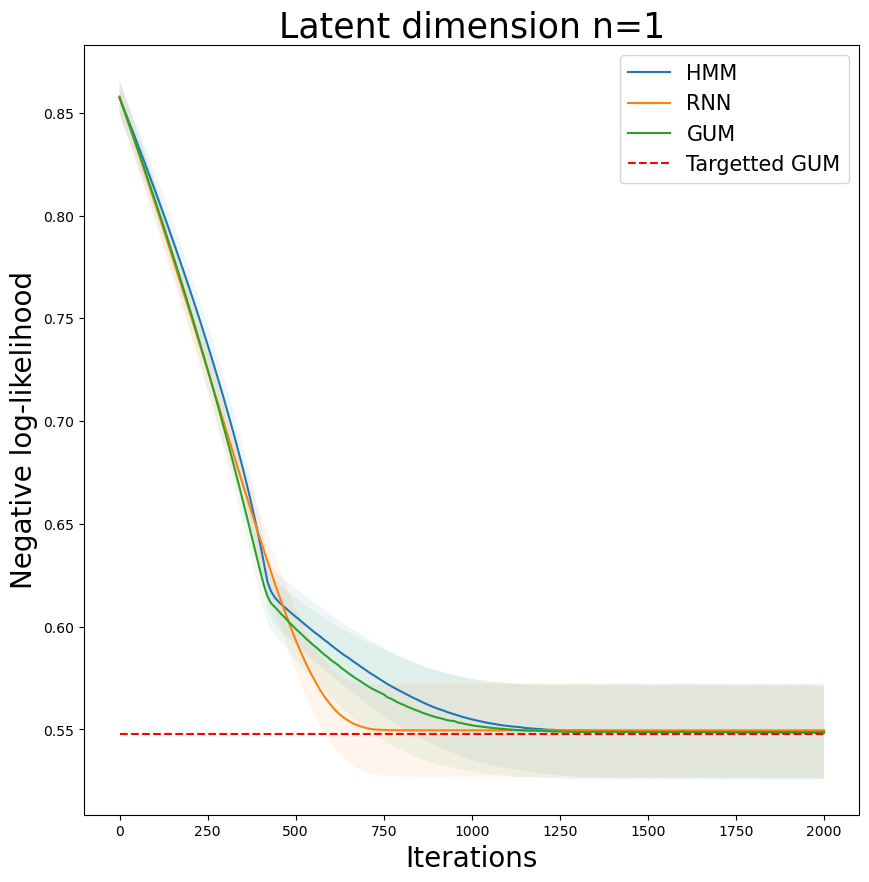

In [59]:
i = -1

means_hmm_ = means_hmm[:i]
stds_hmm_t = [m+s for m,s in zip(means_hmm_, stds_hmm[:len(means_hmm_)])]
stds_hmm_d = [m-s for m,s in zip(means_hmm_, stds_hmm[:len(means_hmm_)])]

means_rnn_ = means_rnn[:i]
stds_rnn_t = [m+s for m,s in zip(means_rnn_, stds_rnn[:len(means_rnn_)])]
stds_rnn_d = [m-s for m,s in zip(means_rnn_, stds_rnn[:len(means_rnn_)])]

means_gum_ = means_gum[:i]
stds_gum_t = [m+s for m,s in zip(means_gum_, stds_rnn[:len(means_gum_)])]
stds_gum_d = [m-s for m,s in zip(means_gum_, stds_rnn[:len(means_gum_)])]

means_unknown_gum_ = [unknown_gum_mean for _ in range(max(len(means_hmm_),len(means_rnn_)))]
x          = [x_*size_batch for x_ in range(len(means_unknown_gum_))]

plt.figure(figsize=(10, 10))

plt.plot(x, means_hmm_, label="HMM")
plt.fill_between(x, stds_hmm_d, stds_hmm_t, alpha=0.07)

plt.plot(x, means_rnn_, label="RNN")
plt.fill_between(x, stds_rnn_d, stds_rnn_t, alpha=0.07)

plt.plot(x, means_gum_, label="GUM")
plt.fill_between(x, stds_gum_d, stds_gum_t, alpha=0.07)



plt.plot(x, means_unknown_gum_, "r--", label="Targetted GUM")
plt.legend(fontsize=15)

plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Negative log-likelihood", fontsize=20)
plt.title("Latent dimension n={0}".format(n), fontsize=25)
plt.show()

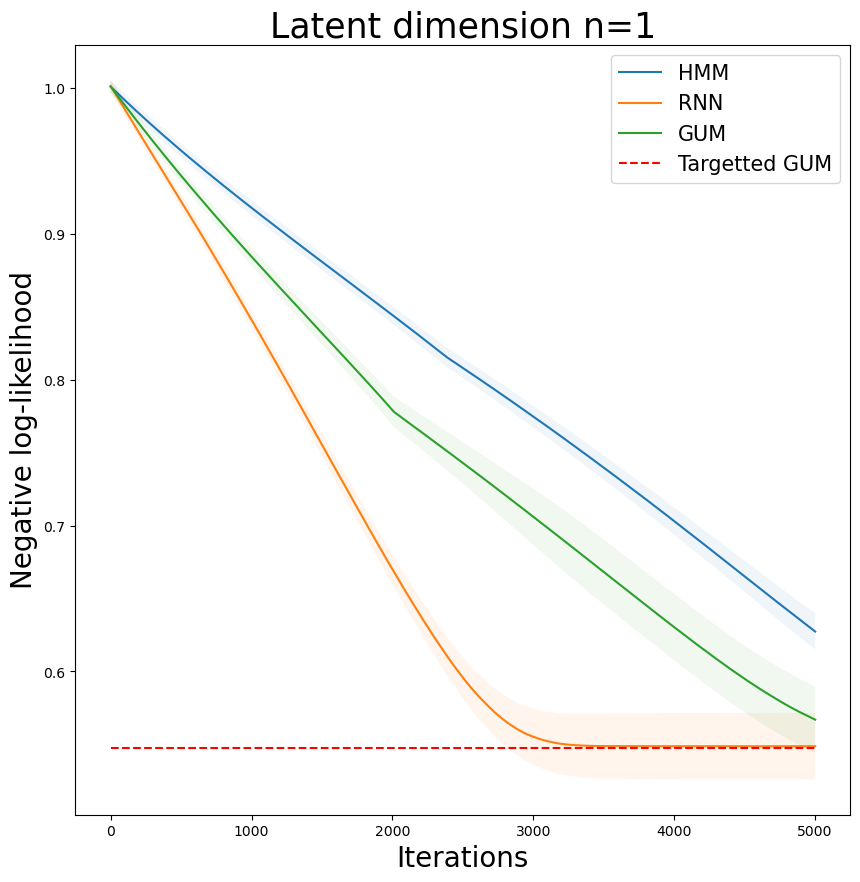

In [18]:
i = -1

means_hmm_ = means_hmm[:i]
stds_hmm_t = [m+s for m,s in zip(means_hmm_, stds_hmm[:len(means_hmm_)])]
stds_hmm_d = [m-s for m,s in zip(means_hmm_, stds_hmm[:len(means_hmm_)])]

means_rnn_ = means_rnn[:i]
stds_rnn_t = [m+s for m,s in zip(means_rnn_, stds_rnn[:len(means_rnn_)])]
stds_rnn_d = [m-s for m,s in zip(means_rnn_, stds_rnn[:len(means_rnn_)])]

means_gum_ = means_gum[:i]
stds_gum_t = [m+s for m,s in zip(means_gum_, stds_rnn[:len(means_gum_)])]
stds_gum_d = [m-s for m,s in zip(means_gum_, stds_rnn[:len(means_gum_)])]

means_unknown_gum_ = [unknown_gum_mean for _ in range(max(len(means_hmm_),len(means_rnn_)))]
x          = [x_*size_batch for x_ in range(len(means_unknown_gum_))]

plt.figure(figsize=(10, 10))

plt.plot(x, means_hmm_, label="HMM")
plt.fill_between(x, stds_hmm_d, stds_hmm_t, alpha=0.07)

plt.plot(x, means_rnn_, label="RNN")
plt.fill_between(x, stds_rnn_d, stds_rnn_t, alpha=0.07)

plt.plot(x, means_gum_, label="GUM")
plt.fill_between(x, stds_gum_d, stds_gum_t, alpha=0.07)



plt.plot(x, means_unknown_gum_, "r--", label="Targetted GUM")
plt.legend(fontsize=15)

plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Negative log-likelihood", fontsize=20)
plt.title("Latent dimension n={0}".format(n), fontsize=25)
plt.show()